# Building a Chatbot Agent in LangGraph

In this tutorial, we will build a support chatbot using LangGraph. We will implement this chatbot via a graph workflow using nodes and edges.

The chatbot will:

- Answer common questions by searching the web.
- Use custom tools to enhance its capabilities.
- Maintain conversation state across calls.

This tutorial builds the foundation for more complex workflows and design patterns later in the course.

### Imports
We start by importing the necessary libraries:

In [1]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from datetime import datetime
from typing import Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv
_ = load_dotenv()

### Defining the Model
Initialize the language model:

In [2]:
llm = ChatOpenAI(model="gpt-4o")

### Defining the Tools
We will define two tools:

- Tavily Search Tool: To fetch relevant information from the web.
- Current Date and Time Tool: Helps the chatbot respond to time-based queries.


In [3]:
# Tavily Search Tool
tavily_search = TavilySearchResults(max_results=2)

# Current Date and Time Tool
@tool
def get_current_date():
    """Returns the current date and time. Use this tool first for any time-based queries."""
    return f"The current date is: {datetime.now().strftime('%d %B %Y')}"

In [4]:
# list of tools for the agent
tools = [tavily_search, get_current_date]

### Binding Tools to the LLM
We bind the tools to the language model:

In [5]:
llm_with_tools = llm.bind_tools(tools)

### Defining the StateGraph
We define the state of our chatbot using StateGraph. The State consists of a messages list, which will store the conversation history.


In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Defining the Graph Nodes
We define a chatbot node, which represents the LLM's response generation. We also define a tool node to handle tool calls.

In [7]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [8]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

### Defining the Graph Edges
We define how the chatbot transitions between nodes:

In [9]:
# Conditional edge to decide whether to use tools, this is a prebuilt conditional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)

# If tools are used, return to the chatbot to process the tool output
graph_builder.add_edge("tools", "chatbot")

# Set the entry point of the graph
graph_builder.set_entry_point("chatbot")

### Compiling the Graph
We compile the graph to create a runnable chatbot:

In [10]:
graph = graph_builder.compile()

### Visualizing the Chatbot's Workflow
We can visualize the chatbot's workflow using LangGraph's graph visualization tools:

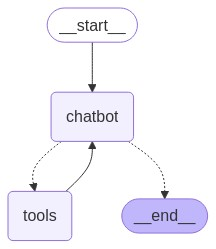

In [11]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Chatbot
Now, we can interact with our chatbot.

#### Helper Functions
We define helper functions to process and render the chatbot's responses:

In [12]:
from IPython.display import Markdown, display

def render_markdown(md_string):
    display(Markdown(md_string))

def process_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
    return message

def process_query(query, config=None):
    inputs = {"messages": [("user", query)]}
    message = process_stream(graph.stream(inputs, config, stream_mode="values"))
    render_markdown(f"## Answer:\n{message.content}")


#### Testing the Chatbot
We can now test the chatbot with various queries:

In [13]:
process_query("Hello! What can you do?")

================================ Human Message =================================

Hello! What can you do?


python(64751) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


================================== Ai Message ==================================

Hello! I can assist with a variety of tasks, including:

- Answering questions and providing information on a wide range of topics.
- Conducting searches for current events or specific queries.
- Providing the current date and time.
- Offering explanations, summaries, and recommendations.
- Assisting with problem-solving and decision-making.

If you have any specific questions or tasks, feel free to ask!


## Answer:
Hello! I can assist with a variety of tasks, including:

- Answering questions and providing information on a wide range of topics.
- Conducting searches for current events or specific queries.
- Providing the current date and time.
- Offering explanations, summaries, and recommendations.
- Assisting with problem-solving and decision-making.

If you have any specific questions or tasks, feel free to ask!

In [14]:
# Query that requires current date
process_query("What is the current date?")

================================ Human Message =================================

What is the current date?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_NRLRfT9OgaVTBzabfAbyMHcL)
 Call ID: call_NRLRfT9OgaVTBzabfAbyMHcL
  Args:
================================= Tool Message =================================
Name: get_current_date

The current date is: 04 April 2025
================================== Ai Message ==================================

Today's date is April 4, 2025.


## Answer:
Today's date is April 4, 2025.

In [15]:
# Query that triggers the Tavily search tool
process_query("What is LangGraph?")

================================ Human Message =================================

What is LangGraph?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_3G3IgCyN5oDRXsJDGFDhKH0m)
 Call ID: call_3G3IgCyN5oDRXsJDGFDhKH0m
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for d

## Answer:
LangGraph is a Python library designed to build stateful, cyclic, and multi-actor applications using Large Language Models (LLMs). It is an extension of LangChain, providing tools for creating sophisticated workflows and state machines that facilitate the coordination of multiple AI agents or interactions with language models. LangGraph is particularly useful for developing complex applications by implementing them as directed graphs, where nodes represent actions (such as calling a function) and edges dictate the flow between these actions.

In [16]:
# Time-based query about an event
process_query("When is the next olympics?")

================================ Human Message =================================

When is the next olympics?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_DVRbhrLXNfuh5MQP2TUwdR2q)
 Call ID: call_DVRbhrLXNfuh5MQP2TUwdR2q
  Args:
================================= Tool Message =================================
Name: get_current_date

The current date is: 04 April 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_4TkSpy4UCbW5RxJLT4eFmLOQ)
 Call ID: call_4TkSpy4UCbW5RxJLT4eFmLOQ
  Args:
    query: next Olympic Games date 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/2026_Winter_Olympics", "content": "^ \"Milano Cortina 2026 and the Olympic Torch: A journey without equal\". Inside the Games. 27 November 2024. Archived from the

## Answer:
The next Olympic Games will be the 2026 Winter Olympics, which will take place in Milan-Cortina, Italy.

## Need for Memory

Taking a look at an example of where the current chatbot falls short when remembering previous interactions.

In [17]:
process_query("Hi. My name is Sajal. Who are you?")

================================ Human Message =================================

Hi. My name is Sajal. Who are you?
================================== Ai Message ==================================

Hello Sajal! I'm an AI assistant designed to help you with a variety of tasks and answer your questions. How can I assist you today?


## Answer:
Hello Sajal! I'm an AI assistant designed to help you with a variety of tasks and answer your questions. How can I assist you today?

In [18]:
process_query("What is my name?")

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. If you've mentioned your name earlier, I don't have the capability to recall it. Let me know if there's anything else I can assist you with!


## Answer:
I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. If you've mentioned your name earlier, I don't have the capability to recall it. Let me know if there's anything else I can assist you with!

### Adding Memory to the Chatbot
To maintain conversation state across calls, we use LangGraph's checkpointing system.

#### Setting Up Checkpointing
We create a MemorySaver checkpointer:

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [20]:
# Compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)

#### Using Thread IDs for Conversation State
We can maintain separate conversation threads by providing a thread_id in the configuration:

In [21]:
config_user_1 = {"thread_id": "user_1"}
process_query("Hi. My name is Sajal. Who are you?", config=config_user_1)

================================ Human Message =================================

Hi. My name is Sajal. Who are you?
================================== Ai Message ==================================

Hello Sajal! I'm an AI assistant here to help you with information, answer questions, and assist with a variety of tasks. How can I assist you today?


## Answer:
Hello Sajal! I'm an AI assistant here to help you with information, answer questions, and assist with a variety of tasks. How can I assist you today?

In [22]:
process_query("What is my name?", config=config_user_1)

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Sajal.


## Answer:
Your name is Sajal.

In [23]:
# Checking if memory is shared across threads
config_user_2 = {"thread_id": "user_2"}
process_query("What is my name?", config=config_user_2)

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. Therefore, I don't know your name. If you'd like, you can tell me your name.


## Answer:
I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. Therefore, I don't know your name. If you'd like, you can tell me your name.

In [25]:
# Time-based query about an event
process_query("Who is Donald Trump?", config=config_user_1)

================================ Human Message =================================

Who is Donald Trump?
================================== Ai Message ==================================

Donald Trump is an American businessman, television personality, and politician who served as the 45th President of the United States from January 20, 2017, to January 20, 2021. Before his presidency, he was known for his real estate business, primarily through his company, The Trump Organization, and for hosting the reality TV show "The Apprentice."

Trump is a member of the Republican Party and has been a prominent and often controversial figure in American politics and media. His presidency was marked by significant policy changes, a focus on "America First" initiatives, and a divisive style of communication. After his presidency, he has remained an influential figure in American politics.


## Answer:
Donald Trump is an American businessman, television personality, and politician who served as the 45th President of the United States from January 20, 2017, to January 20, 2021. Before his presidency, he was known for his real estate business, primarily through his company, The Trump Organization, and for hosting the reality TV show "The Apprentice."

Trump is a member of the Republican Party and has been a prominent and often controversial figure in American politics and media. His presidency was marked by significant policy changes, a focus on "America First" initiatives, and a divisive style of communication. After his presidency, he has remained an influential figure in American politics.

### Conclusion


Congratulations on building your own chatbot agent from scratch with LangGraph. Be sure to go through the next few tutorials to learn more about adding human in the loop capabilities to this agent!
